In [1]:
# This script assists in determining the gain offset and phase offset needed to calibrate the polarimeter.

# Assumes a +45 degree linear calibration source and a reflecting sensor such as a dish antenna.

In [2]:
%matplotlib inline
import csv
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
object_observed ="Calibration Source"
frequency = "2287.000"

In [4]:
# plot variables
mark_size = 5

# gnuradio settings
nfft = 4096
samp_rate = 1e6
decim1 = 16
integ = 10

integrate = int(samp_rate/decim1/nfft*integ)
print(integrate) # print this to double check :-)

#observation details
site = 8049
directory_path = '/home/scott/blade_test/'

filename_pattern = '*.xx.f32'

latest_file = max(glob.glob(os.path.join(directory_path, filename_pattern)), key=os.path.getctime)

filename_parts = os.path.basename(latest_file).split('.')[0].split('_')
date_str = filename_parts[0]  # Format: yyyy-mm-ddThh:mm:ss

date_format = "%Y-%m-%dT%H:%M:%S"
datetime_obj = datetime.strptime(date_str, date_format)
formatted_datetime = datetime_obj.strftime("%Y-%m-%dT%H:%M:%S")

xx = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xx.f32'), dtype='float32').reshape((-1, nfft))
yy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.yy.f32'), dtype='float32').reshape((-1, nfft))
xy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xy.c64'), dtype='complex64').reshape((-1, nfft))

t = np.arange(xx.shape[0]) * integrate * nfft * decim1 / samp_rate * 1e3 * np.timedelta64(1, 'ms') + np.datetime64(datetime_obj)
print("Latest Filename:", latest_file)
print("Datetime:", datetime_obj)

frequency_values = np.arange((samp_rate/decim1)/-2.0, (samp_rate/decim1)/2.0, (samp_rate/decim1)/nfft)
frequency_values += float(frequency) *1e6

152
Latest Filename: /home/scott/blade_test/2023-10-27T01:10:01.xx.f32
Datetime: 2023-10-27 01:10:01


In [5]:
#Calculate gain offset.

peak_column_index = np.argmax(np.max(np.abs(xx), axis=0))

n = 2  # Change this value to the number of initial samples you want to exclude

xx_peak = xx[n:, peak_column_index]
yy_peak = yy[n:, peak_column_index]

# Calculate the gain offset
gain_offset = np.average(xx_peak / yy_peak)
print(gain_offset)
print("peak frequency", frequency_values[peak_column_index])
print("Column Index for Peak Value:", peak_column_index)
print("Gain Offset:", gain_offset)
print("shape of XY: ", np.shape(xy))
yy *= gain_offset
xy *= np.sqrt(gain_offset)
# With a 45degree calibration antenna the Q parameter should be 0 when the gain offset is correct.  


0.6031985
peak frequency 2287003997.8027344
Column Index for Peak Value: 2310
Gain Offset: 0.6031985
shape of XY:  (214, 4096)


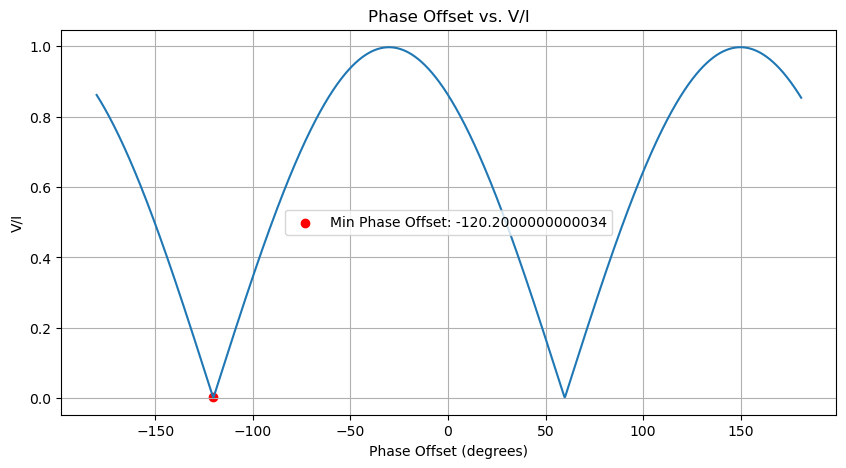

Best phase_offset: -120.2000000000034
Minimum V/I: 0.002741492502801837


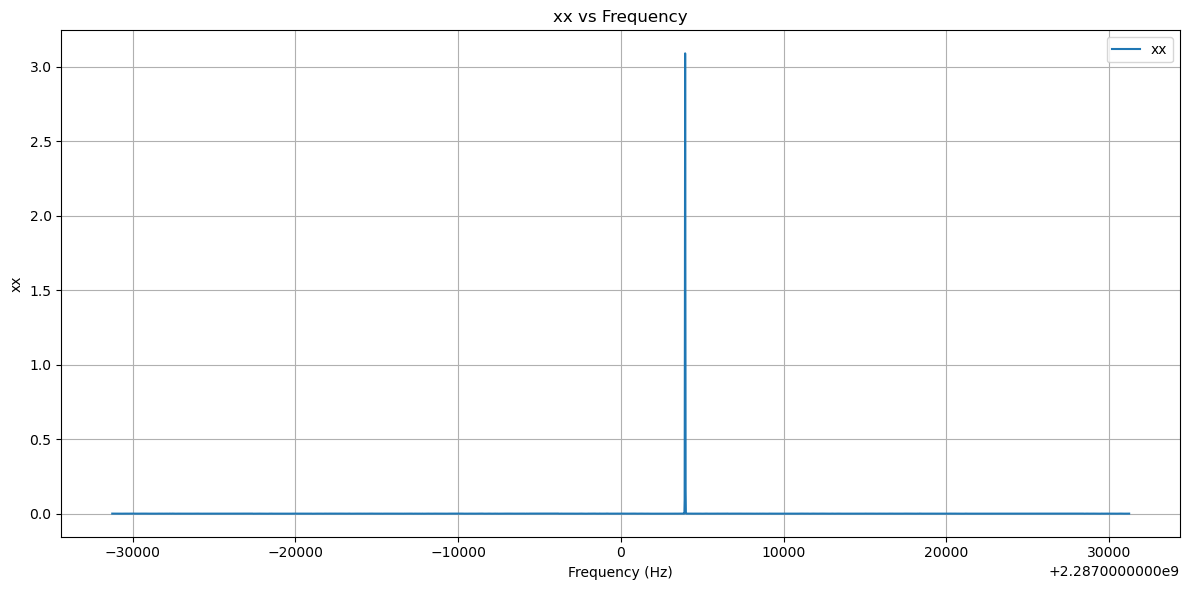

In [6]:
#This code finds the phase_offset that produces the minimum V/I value.  Use this value in your analysis script. 
#thought should be put to the other minima and filtering it based on the calibration hardware.  I.e. check to ensure U is positive...

fractional_step_size = 0.1  # Adjust as needed

best_phase_offset = None
min_v_over_i = float('inf')
v_over_i_values = []
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)

for phase_offset in np.arange(-180, 181, fractional_step_size):  # Use fractional step size
    xy_copy = xy * np.exp(-1j * np.deg2rad(phase_offset)) * (-1j)
    signal_xx = np.zeros(xx.shape[0])
    signal_yy = np.zeros(yy.shape[0])
    signal_xy = np.zeros(xy.shape[0], dtype='complex')

    for offset in np.arange(-2, 3):
        signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
        signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
        signal_xy += xy_copy[np.arange(signal_peak.shape[0]), signal_peak + offset]

    signal_xx /= offsets.size
    signal_yy /= offsets.size
    signal_xy /= offsets.size
    gain_xx_yy = np.median(signal_xx + signal_yy)
    signal_xx /= gain_xx_yy
    signal_yy /= gain_xx_yy
    signal_xy /= gain_xx_yy

    I = signal_xx + signal_yy
    V = 2 * signal_xy.imag
    v_over_i = np.abs(V / I).mean()
    v_over_i_values.append(v_over_i)

    if v_over_i < min_v_over_i:
        min_v_over_i = v_over_i
        best_phase_offset = phase_offset

plt.figure(figsize=(10, 5))
plt.plot(np.arange(-180, 181, fractional_step_size), v_over_i_values)
plt.xlabel('Phase Offset (degrees)')
plt.ylabel('V/I')
plt.title('Phase Offset vs. V/I')
plt.grid()

plt.scatter(best_phase_offset, min_v_over_i, color='red', marker='o', label=f'Min Phase Offset: {best_phase_offset}')

plt.legend()
plt.show()

print("Best phase_offset:", best_phase_offset)
print("Minimum V/I:", min_v_over_i)

xy *= np.exp(-1j*np.deg2rad(best_phase_offset))*(-1j) # correct for X-Y phase offset

plt.figure(figsize=(12, 6))
plt.plot(frequency_values, xx[-1, :], label='xx', markersize=mark_size)
plt.title('xx vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('xx')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [7]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [8]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = 2*signal_xy.imag #- removed to componsate for reflection in dish so the polarization is seen looking at source.
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

Text(0.5, 1.0, 'Calibration Source 2287.000MHz Stokes Parameters, 2023-10-27T01:10:01')

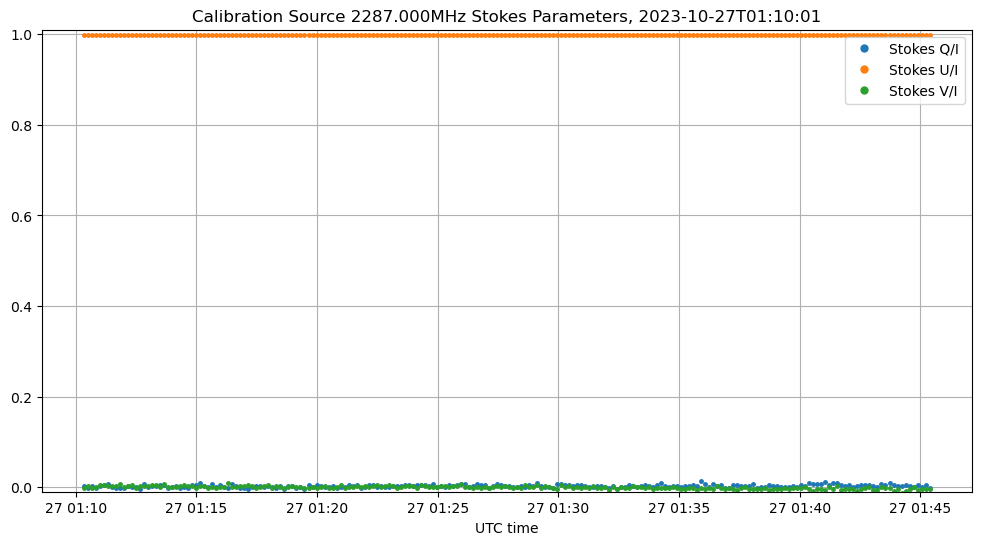

In [9]:
sel = slice(n,None)
plt.figure(figsize=(12, 6))
plt.grid(True)

plt.plot(t[sel], (Q/I)[sel], '.', markersize=mark_size)
plt.plot(t[sel], (U/I)[sel], '.', markersize=mark_size)
plt.plot(t[sel], (V/I)[sel], '.', markersize=mark_size)
legend = plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)

plt.ylim(-0.01, 1.01)
title_text = f'{object_observed} {frequency}MHz Stokes Parameters, {formatted_datetime}'
plt.title(title_text)

Polarization angle:  44.89444825396537


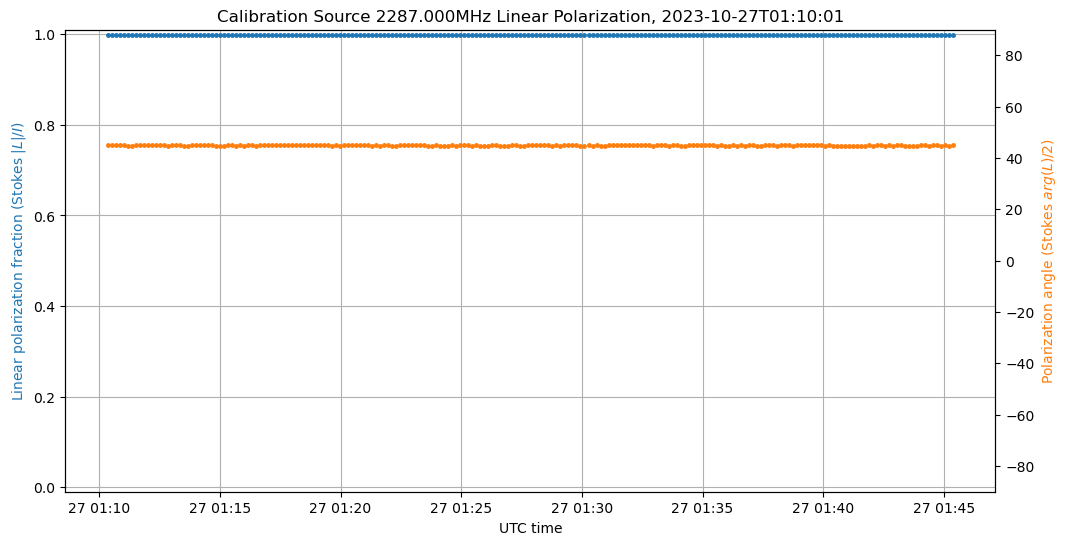

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (np.abs(L[sel])/I[sel]), '.', markersize=mark_size)
plt.grid(True)
plt.ylim((-0.01,1.01))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color = 'C0')
ax2 = plt.gca().twinx()
plt.plot(t[sel], np.rad2deg(np.angle(L[sel])/2), '.', color = 'C1', markersize=mark_size)
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
ax2.set_ylim((-90,90))
title_text = f'{object_observed} {frequency}MHz Linear Polarization, {formatted_datetime}'
plt.title(title_text)
print("Polarization angle: ",np.average(np.rad2deg(np.angle(L)/2))) #should be +45 degrees.

Text(0.5, 1.0, 'Calibration Source 2287.000MHz Stokes Q 2023-10-27T01:10:01')

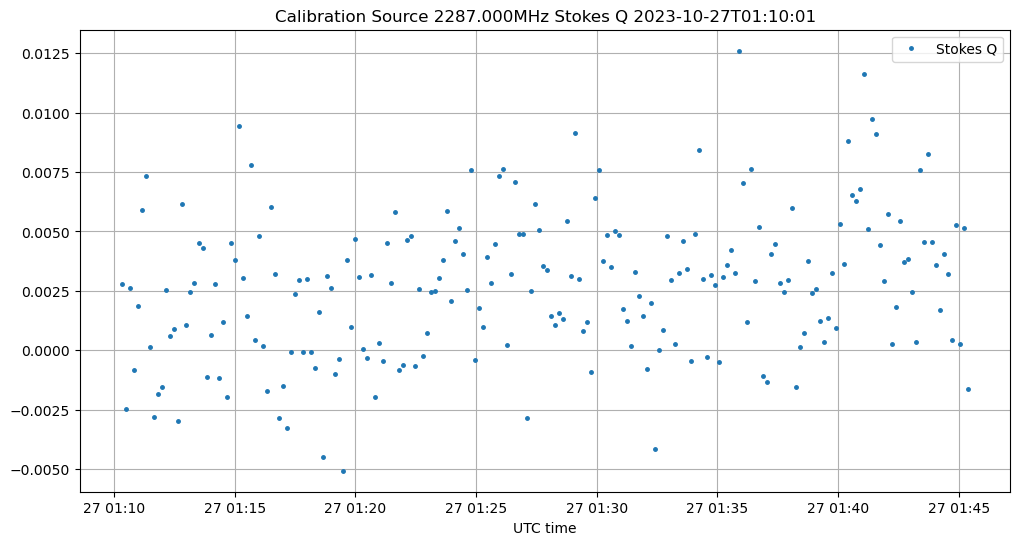

In [11]:
#Stokes Q should be 0 if offset is correct.
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(t[sel], Q[sel],'.',  markersize=mark_size)
plt.legend(['Stokes Q'])
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Q {formatted_datetime}'
plt.title(title_text)

Text(0.5, 1.0, 'Calibration Source 2287.000MHz Stokes V, 2023-10-27T01:10:01')

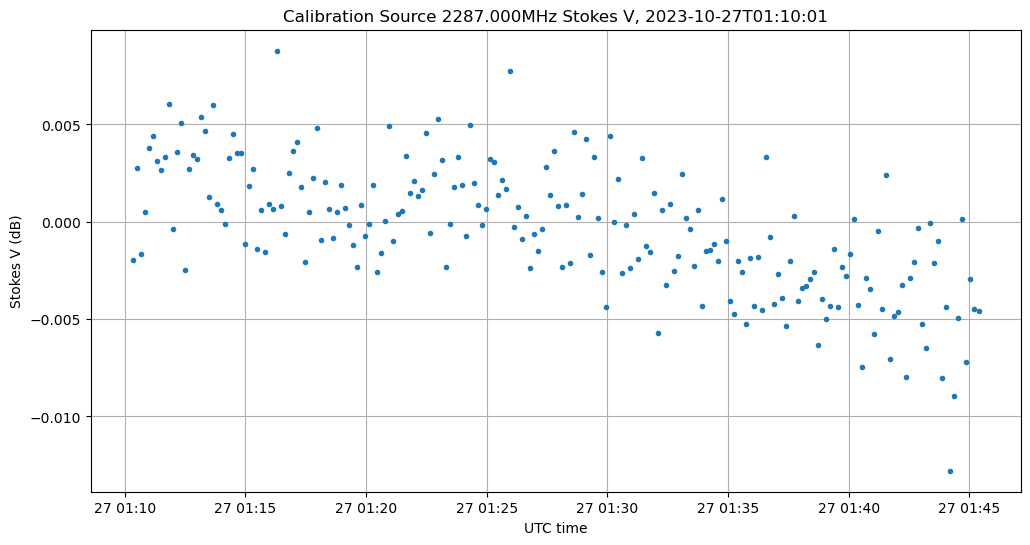

In [12]:
# Stokes V should be 0 if phase offset is correct.
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(t[sel], V[sel], '.')
plt.xlabel('UTC time')
plt.ylabel('Stokes V (dB)')
title_text = f'{object_observed} {frequency}MHz Stokes V, {formatted_datetime}'
plt.title(title_text)